In [1]:
# Import as usual
from Utils.Pipeline_functions import * # contains all the functions also defined in the cells below
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import cv2
import glob
import random

# for auto reloading the Utils functions
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Calibrate camera

#### Detect chessboard corners
Based on Udacity's [Camera Calibration repository](https://github.com/udacity/CarND-Camera-Calibration)

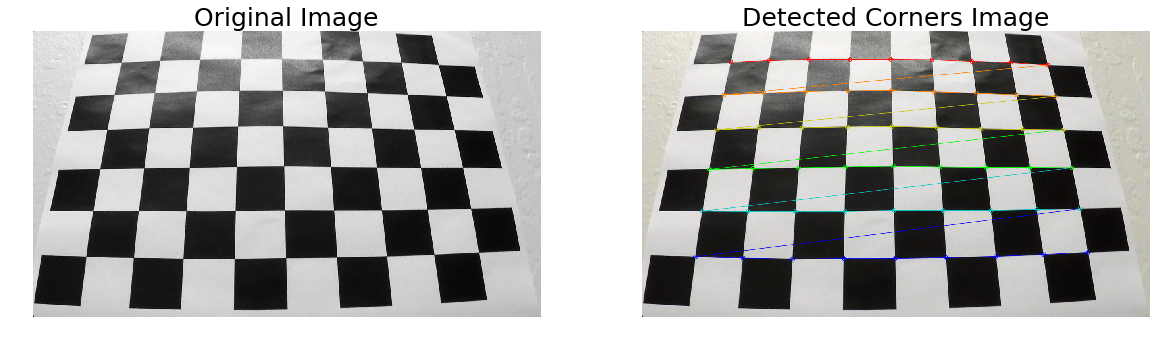

In [4]:
# amount of row and colums for chessboard corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
detect_id = [] # store index of images with detected corners
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = np.array(cv2.imread(fname))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    # If found, add object points, image points
    if ret == True:
        detect_id.append(idx)
        objpoints.append(objp)
        imgpoints.append(corners)

# Visualize corner detection on random image
rand_img   = cv2.imread('camera_cal/calibration'+str(random.choice(detect_id))+'.jpg')
gray       = cv2.cvtColor(rand_img, cv2.COLOR_BGR2GRAY)
_, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
rand_img   = cv2.drawChessboardCorners(rand_img, (nx,ny), corners, ret)
fig, plts   = plt.subplots(1,2, figsize=(20,10))
plts[0].imshow(gray, cmap='gray');    plts[0].axis('off'); plts[0].set_title('Original Image', fontsize=25)
plts[1].imshow(rand_img[:, :, ::-1]); plts[1].axis('off'); plts[1].set_title('Detected Corners Image', fontsize=25)
fig.savefig('output_images/Chessboard_corners_found.jpg')
plt.show()

#### Calculate undistort parameters

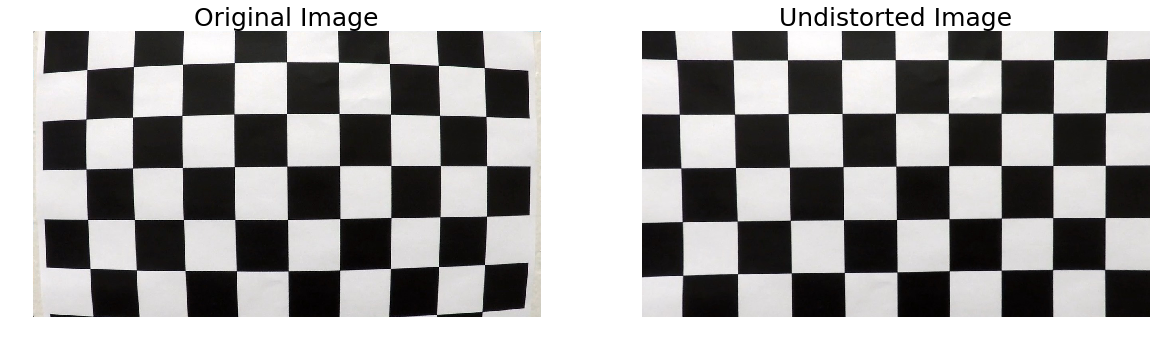

In [5]:
# Test undistortion on image 'calibration1.jpg' - has the easiest to see distortion
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Calculate camera calibration objects given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Undistort image
un_dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result, they're calculated only once, and don't need to be part of the pipeline
# rvecs / tvecs aren't used
cal_params = {}
cal_params["mtx"] = mtx
cal_params["dist"] = dist
pickle.dump( cal_params, open( "camera_cal/camera_calibration_parameters_pickle.p", "wb" ) )

# Visualize undistortion
fig, plts = plt.subplots(1, 2, figsize=(20,10))
plts[0].imshow(img[:,:,::-1]);      plts[0].axis('off'); plts[0].set_title('Original Image', fontsize=25)
plts[1].imshow(un_dst[:, :, ::-1]); plts[1].axis('off'); plts[1].set_title('Undistorted Image', fontsize=25)
fig.savefig('output_images/Undistorted_chessboard.jpg')
plt.show()

### Filter, threshold and change color space for better lane detection
Based on Udacity's CarND course material

In [6]:
# create full wrapper for multiple thresholding functions
# Efficiency gain: comment out those thresholding functions that are not being used
def threshold_filter_image(img, sob_k=11, sob_thr=(20, 100),
                           sob_angle_k=9, sob_angle_thr=(1/6*math.pi, 1.3),
                           r_thr=(150, 255), s_thr=(170, 255), h_thr=(15, 90)):
    
    sx_binary         = sob_threshold(img, orient='x', sobel_kernel=sob_k, thresh=sob_thr)
    sy_binary         = sob_threshold(img, orient='y', sobel_kernel=sob_k, thresh=sob_thr)
    sa_binary         = sob_angle_threshold(img, sobel_kernel=sob_angle_k, thresh=sob_angle_thr)
    r_binary          = bgr_threshold(img, channel_choice='r', thresh=r_thr)
    s_binary          = hls_threshold(img, channel_choice='s', thresh=s_thr)
    h_binary          = hls_threshold(img, channel_choice='h', thresh=h_thr)
    
    # Create binary output filter(s)
    final_binary = np.zeros_like(img[:, :, 0])
    # Choosewhich and how to combine different masks (hyperparameter)
    #setting #1:
    final_binary[(sy_binary==0) & ((h_binary == 1) & (r_binary == 1) & (s_binary == 1) | (sx_binary == 1))] = 1
    #setting #2:
    #final_binary[((h_binary == 1) & (s_binary == 1)) | (sx_binary == 1)] = 1
    #setting #3:
    #final_binary[((sx_binary == 1) | (s_binary == 1)) & (sa_binary == 1)] = 1
    
    return final_binary

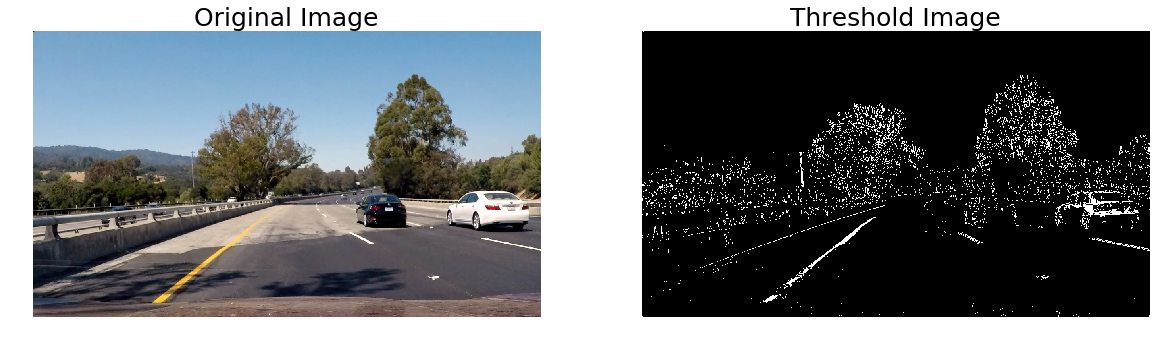

In [7]:
# Visualize full thresholding on sample image
img    = cv2.imread('test_images/test4.jpg')
H, W   = img.shape[:2]
binary = threshold_filter_image(img, sob_k=11, sob_thr=(20, 100),
                                sob_angle_k=9, sob_angle_thr=(1/6*math.pi, 1.3),
                                r_thr=(150, 255), s_thr=(170, 255), h_thr=(15, 90))

fig, plts = plt.subplots(1, 2, figsize=(20,10))
plts[0].imshow(img[:,:,::-1]);       plts[0].axis('off'); plts[0].set_title('Original Image', fontsize=25)
plts[1].imshow(binary, cmap='gray'); plts[1].axis('off'); plts[1].set_title('Threshold Image', fontsize=25)
fig.savefig('output_images/Binary_threshold.jpg')
plt.show()

### Warp image to birds-eye view

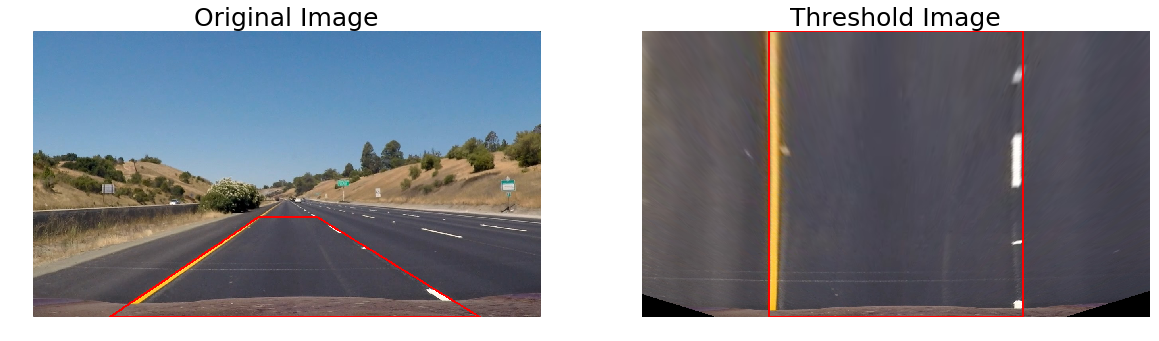

In [9]:
# Load in image
img  = np.dstack((binary, binary, binary))*255
img  = cv2.imread('test_images/straight_lines1.jpg')

# Decide source and destination points
src = np.float32([[0.15*W, H], [0.444*W, 0.65*H], [0.56*W, 0.65*H], [0.88*W, H]])
dst = np.float32([[0.25*W, H], [0.25*W, 0],       [0.75*W, 0],      [0.75*W, H]])
    
# Warp image through helper function
wrp = warp_image(img, src, dst)

# Draw the lines on the image
cv2.polylines(img, [np.int32(src.reshape(-1,1,2))], True, (0,0,255), thickness=3)
cv2.polylines(wrp, [np.int32(dst.reshape(-1,1,2))], True, (0,0,255), thickness=3)

# Visualize the warp
fig, plts = plt.subplots(1, 2, figsize=(20,10))
plts[0].imshow(img[:,:,::-1]); plts[0].axis('off'); plts[0].set_title('Original Image', fontsize=25)
plts[1].imshow(wrp[:,:,::-1]); plts[1].axis('off'); plts[1].set_title('Threshold Image', fontsize=25)
fig.savefig('output_images/Warp_transform.jpg')
plt.show()

### Detect lines in warped image
Based on Udacity's CarND course material

To average over detections for robustness, define a detection history object

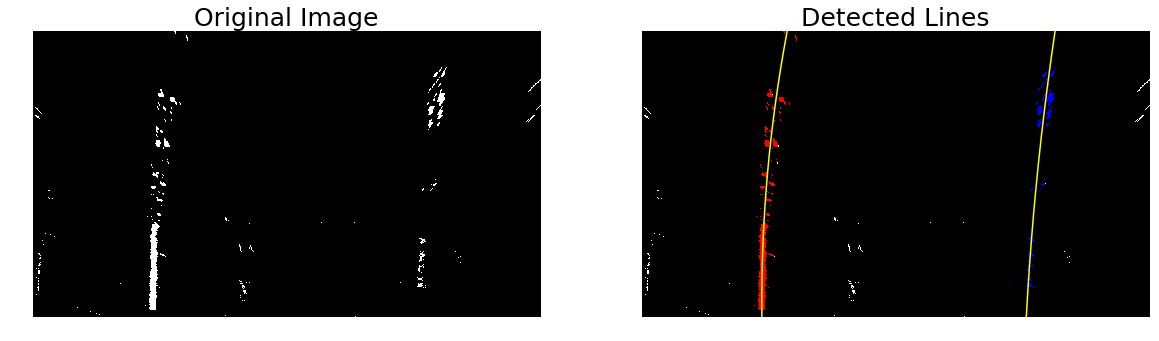

In [11]:
# Read in and warp a test image
#img    = cv2.imread('test_images/straight_lines1.jpg')
img    = cv2.imread('test_images/test5.jpg')
binary = threshold_filter_image(img)
wrp    = warp_image(binary)
H, W   = img.shape[:2]

# Initialize detection history class object
det_hist = detection_history()

# Detect lines
l_curve, r_curve, l_ind_y, l_ind_x, r_ind_y, r_ind_x = detect_lines(wrp, win_w=80, win_h=80,
                                                                    margin=150, det_hist=det_hist)
# Create color space black mask for line drawing
wrp_lines = np.dstack((wrp, wrp, wrp)) * 255

# Copy warped binary into 3-channel image and show line pixel detections
wrp_lines[l_ind_y, l_ind_x] = [0, 0, 255]
wrp_lines[r_ind_y, r_ind_x] = [255, 0, 0]

# Generate x and y values for plotting curves
curve_y   = np.linspace(0, wrp.shape[0]-1, wrp.shape[0] )
l_curve_x = l_curve[0]*curve_y**2 + l_curve[1]*curve_y + l_curve[2]
r_curve_x = r_curve[0]*curve_y**2 + r_curve[1]*curve_y + r_curve[2]

# Visualize the detected lines
fig, plts = plt.subplots(1, 2, figsize=(20,10))
plts[0].imshow(wrp, cmap='gray');       plts[0].axis('off'); plts[0].set_title('Original Image', fontsize=25)
plts[1].imshow(wrp_lines[:,:,::-1]); plts[1].axis('off'); plts[1].set_title('Detected Lines', fontsize=25)
plts[1].plot(l_curve_x, curve_y, color='yellow'); plts[1].plot(r_curve_x, curve_y, color='yellow')
fig.savefig('output_images/Line_detections.jpg')
plt.show()

### Detect curvature of detected lines

In [12]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

l_curve_rad, r_curve_rad = detect_radii(l_curve, r_curve, H, ym_per_pix, xm_per_pix)
print('left curve radius: {:.2f}m, right curve radius: {:.2f}m'.format(l_curve_rad, r_curve_rad))

left curve radius: 1194.01m, right curve radius: 2526.25m


##### Update the detection history object to store the correct annotation information
This information is required when annotating an image

In [13]:
check = det_hist.updater(l_curve, r_curve, l_curve_rad, r_curve_rad, xm_per_pix, H, W)

### Warp detections back onto unwarped image, and annotate all our findings

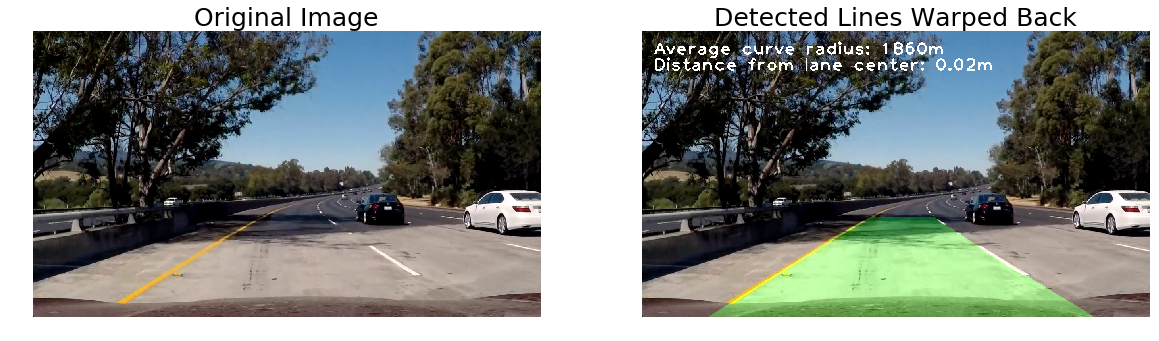

In [14]:
# Load in the original picture
img    = cv2.imread('test_images/test5.jpg')

# NB make sure the correct det_hist is passed here
annotated = annotate(img, wrp.shape[0], wrp.shape[1], det_hist)

# Visualize the warped back lines
fig, plts = plt.subplots(1, 2, figsize=(20,10))
plts[0].imshow(img[:,:,::-1]);       plts[0].axis('off');
plts[0].set_title('Original Image', fontsize=25)
plts[1].imshow(annotated[:,:,::-1]); plts[1].axis('off');
plts[1].set_title('Detected Lines Warped Back', fontsize=25)
fig.savefig('output_images/line_detections.jpg')
plt.show()

### Create full pipeline
All above cells (except for first) are standalone implementations of the pipeline functions. Only this cell below here is necessary however to run before the full-video-generating cell below it can work (including loading in the calibration parameters)

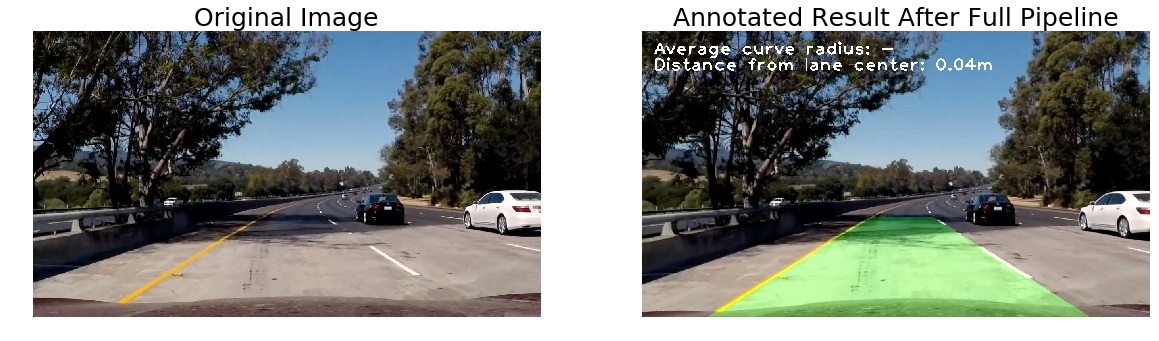

In [16]:
# load in the calibration parameters
cal_params = pickle.load( open( "camera_cal/camera_calibration_parameters_pickle.p", "rb" ) )
mtx        = cal_params["mtx"]
dist       = cal_params["dist"]
# meters per pixel ratios
ym_per_pix = 30/720; xm_per_pix = 3.7/700

def full_pipeline(det_hist, img, mtx, dist, ym_per_pix=ym_per_pix, xm_per_pix=xm_per_pix, src=None, dst=None):
    H, W = img.shape[:2]
    # Undistort the image
    un_dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Threshold the undistorted image
    binary = threshold_filter_image(un_dst, sob_k=11, sob_thr=(20, 100),
                                    sob_angle_k=9, sob_angle_thr=(1/6*math.pi, 1.3),
                                    r_thr=(150, 255), s_thr=(170, 255), h_thr=(15, 90))
    # Warp the binary to a birds-eye view
    warped = warp_image(binary, src, dst)
    # Detect lines
    l_curve, r_curve, l_ind_y, l_ind_x, r_ind_y, r_ind_x = detect_lines(warped, win_w=80, win_h=80,
                                                                        margin=100, det_hist=det_hist)
    # Detect curvatures in meters
    l_curve_rad, r_curve_rad = detect_radii(l_curve, r_curve, H, ym_per_pix, xm_per_pix)
    # Update detection history object
    check = det_hist.updater(l_curve, r_curve, l_curve_rad, r_curve_rad, xm_per_pix, H, W)
    # Create annotated image
    annotated = annotate(un_dst, warped.shape[0], warped.shape[1], det_hist)
    
    return annotated

img       = cv2.imread('test_images/test5.jpg')
det_hist  = detection_history()
annotated = full_pipeline(det_hist, img, mtx, dist, ym_per_pix, xm_per_pix)

# Visualize the warped back lines
fig, plts = plt.subplots(1, 2, figsize=(20,10))
plts[0].imshow(img[:,:,::-1]);       plts[0].axis('off');
plts[0].set_title('Original Image', fontsize=25)
plts[1].imshow(annotated[:,:,::-1]); plts[1].axis('off');
plts[1].set_title('Annotated Result After Full Pipeline', fontsize=25)
plt.show()


### Annotate an entire video

In [18]:
# This is what it is all about: use our pipeline and annotate an entire video

# Initialize detection history object
global det_hist
det_hist  = detection_history(moving_avg=0.7, verbose=False)

# Choose which video to annotate, and get meta data
vid_file  = 'project_video' # 'project_video', 'challenge_video', 'harder_challenge_video'
vid_in    = cv2.VideoCapture('videos/'+vid_file+'.mp4')
vid_len   = int(vid_in.get(cv2.CAP_PROP_FRAME_COUNT))
vid_W     = int(vid_in.get(cv2.CAP_PROP_FRAME_WIDTH))
vid_H     = int(vid_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
vid_fps   =     vid_in.get(cv2.CAP_PROP_FPS)
vid_ind   = 0

# Initialize video writer
fourcc    = cv2.VideoWriter_fourcc(*'avc1')
vid_out   = cv2.VideoWriter('videos/'+vid_file+'_annotated.mp4', fourcc, vid_fps, (vid_W, vid_H))

while(vid_in.isOpened()):
    # keep track of frame index and print progress
    print('Annotating frame {}/{}'.format(vid_ind,vid_len), end='\r'); vid_ind +=1
    #print('Annotating frame {}/{}'.format(vid_ind,vid_len)); vid_ind +=1
    # get next frame, annotate and store
    ret, frame = vid_in.read()
    if ret == False: break
    annotated = full_pipeline(det_hist, frame, mtx, dist, ym_per_pix, xm_per_pix)
    vid_out.write(annotated)  

vid_in.release()
vid_out.release()

In [19]:
HTML("""<video width="960" height="540" controls>
    <source src="{0}"></video>""".format('videos/'+vid_file+'_annotated.mp4'))